In [2]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jit
import jax
from functools import partial

atoms = '''
H        2.0000000000      0.0000000000      0.0000000000
H        0.0000000000      0.0000000000      0.0000000000
'''

frozen = 0

mol = gto.M(atom=atoms,
            basis='sto6g',
            spin=0,
            unit='B',
            verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Tue Feb  3 21:49:03 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      1.058354421840   0.000000000000   0.000000000000 AA    2.000000000000   0.000000000000   0.000000000000 Bohr  

In [3]:
data = np.load('/home/sharmagroup/sharmagroup/project/abs/h2/traject.npz')
t = data["time"]
wts = data["weights"]
ens = data["energies"]

In [4]:
t0 = np.hstack([[0], t])
ntrj = wts.shape[1]
e_init = jnp.full((1, ntrj), mf.e_tot)
wt_init = jnp.full((1, ntrj), 200.)
ens0 = np.vstack([e_init, ens])
wts0 = np.vstack([wt_init, wts])
# print(ens_mod.shape)

In [5]:
mean = ens0.mean(axis=1)

In [6]:
std = np.sqrt(np.sum((ens0 - mean[:,None])**2,axis=1))/ntrj

In [7]:
mean

array([-1.05642986+0.00000000e+00j, -1.06913996-1.01549489e-04j,
       -1.07916696-3.18401149e-04j, -1.09188647-5.56764379e-05j,
       -1.10050987-9.20647268e-04j, -1.10856759-9.54404437e-04j,
       -1.09662908+1.44413617e-03j, -1.10194579+1.08424422e-03j,
       -1.09891818+1.55642726e-03j, -1.10008146+1.65870715e-03j,
       -1.09817701+2.71155682e-03j, -1.094508  +2.59425852e-03j,
       -1.09436358+2.50962531e-04j, -1.0898298 -6.92626574e-04j,
       -1.09751548-5.66300167e-04j, -1.1033399 -1.48182970e-03j,
       -1.10567311-1.58127150e-03j, -1.10200926+2.15507367e-03j,
       -1.1021694 +5.75569129e-04j, -1.09473679+9.88238004e-05j,
       -1.09887636+2.23540002e-03j, -1.09457968-8.80203365e-04j,
       -1.09879407+7.44727686e-04j, -1.09698401+9.20572983e-04j,
       -1.09832859+4.63663573e-04j, -1.10528478+9.65022482e-04j,
       -1.09671983+2.29009605e-04j, -1.10469518-8.34004701e-04j,
       -1.09765495-8.09569524e-04j, -1.10409326+5.47782379e-04j,
       -1.10229155+3.5241

In [9]:
ens0.shape

(101, 1)

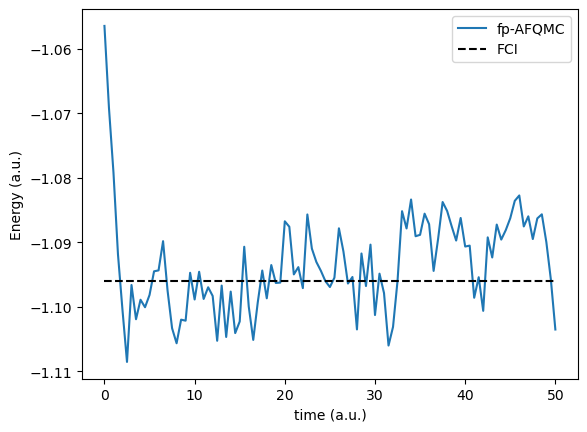

In [10]:
from matplotlib import pyplot as plt
plt.plot(t0, ens0[:,:1].real,'-',color="C0", label='fp-AFQMC')
# plt.plot(t0, ens0[:,1:50].real,'-',color="C0", alpha=0.6)
plt.plot(t0,[mycc.e_tot]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()

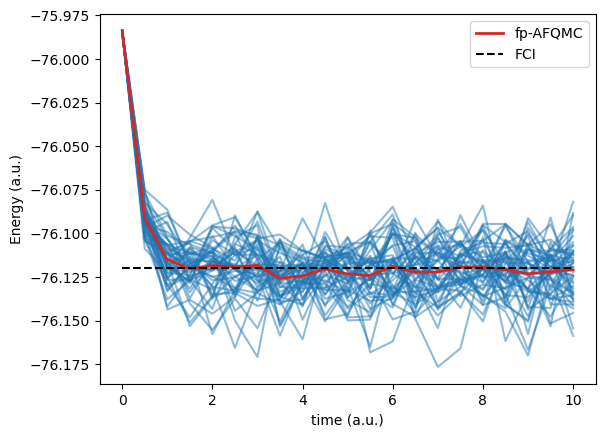

In [79]:
from matplotlib import pyplot as plt
plt.plot(t0, ens0.real,'-',color="C0", alpha=0.5)
# plt.plot(t0, ens0[:,1].real,'o-',label='fp2',color='C1')
# plt.plot(t0, ens0[:,2].real,'o-',label='fp3',color='C2')
# plt.errorbar(t0, mean.real, std.real*2, fmt='.-',capsize=5, color="C3", label='fp-AFQMC')
plt.plot(t0, mean.real, linewidth=2, color="C3", label='fp-AFQMC')
# plt.plot(t0,[mycc.e_tot + et]*len(t0), '--',label='CCSD(T)',color='C4')
plt.plot(t0,[e_fci]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()

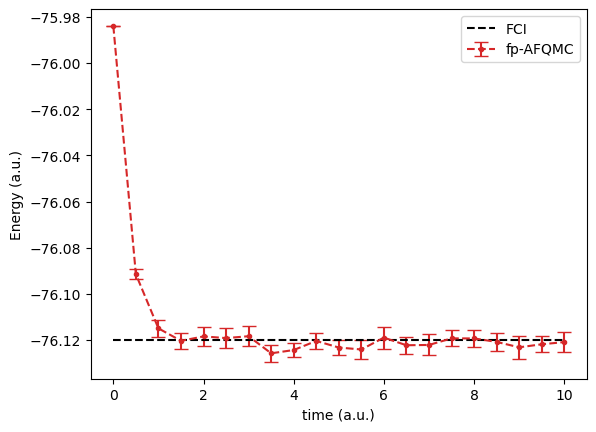

In [76]:
plt.errorbar(t0, mean.real, std.real*2, fmt='.--',capsize=5, color="C3", label='fp-AFQMC')
plt.plot(t0,[e_fci]*len(t0), '--',label='FCI',color='black')
plt.xlabel("time (a.u.)")
plt.ylabel("Energy (a.u.)")
plt.legend()
plt.show()